In [159]:
!pip install pmdarima
!pip install matplotlib
!pip install nb-black

In [160]:
# check pmdarima
from pmdarima.arima import auto_arima

ARIMA
ARIMA (AutoRegressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA models explain a time series based on its own past values, basically its own lags and the lagged forecast errors.

In [161]:
from IPython.core.debugger import set_trace


import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

In [226]:
df = pd.read_csv("/content/NAADP.csv")


In [216]:
df = pd.read_csv("/content/MSFT-1Y-Hourly.csv")
df = df[["close"]].copy()
df

,close
0,132.89
1,134.75
2,133.88
3,133.90
4,134.83
...,...
1748,212.99
1749,211.97
1750,213.35
1751,214.19


In [227]:
df= df.T
df.head(5)

,0
Series Name,Employee Female Ratio
2013-01-31,0.0943
2013-02-28,0.0969
2013-03-31,0.0984
2013-04-30,0.098


In [201]:
# iterating the columns
for col in df.columns:
    print(col)

0


In [258]:
df.rename({0: 'Female'}, axis=1, inplace=True)
df=df.iloc[1: , :]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Female,forecast
2013-03-31,0.0984,NaN
2013-04-30,0.098,NaN
2013-05-31,0.0982,NaN
2013-06-30,0.0975,NaN
2013-07-31,0.1001,NaN
...,...,...
2021-08-31,0.1399,NaN
2021-09-30,0.1421,NaN
2021-10-31,0.1438,NaN
2021-11-30,0.1443,NaN


In [259]:
#headers = df.iloc[0]
#new_df  = pd.DataFrame(df.values[1:], columns=headers)

In [230]:
#new_df = new_df.rename(columns={'Employee Female Ratio': 'Female'})


In [229]:
#df=new_df[["Female"]].copy()
#df

In [351]:
df = pd.read_csv("/content/NAADP2.csv")
df.rename({'Series Name': 'Date'}, axis=1, inplace=True)
# Convert Month into Datetime
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.head()

,Female
Date,
2013-01-31,0.0943
2013-02-28,0.0969
2013-03-31,0.0984
2013-04-30,0.0980
2013-05-31,0.0982


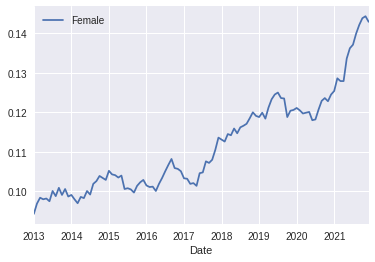

In [268]:
df.plot()

An ARIMA model is characterized by 3 terms (p, d, q):

p is the order of the AR term

d is the number of differencing required to make the time series stationary

q is the order of the MA term

As we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.

Stationarity
Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times.

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model.

ADF test
We'll use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [269]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Female.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 1.0572759271490164
p-value: 0.9948349778805392


In [234]:
from statsmodels.graphics.tsaplots import plot_acf

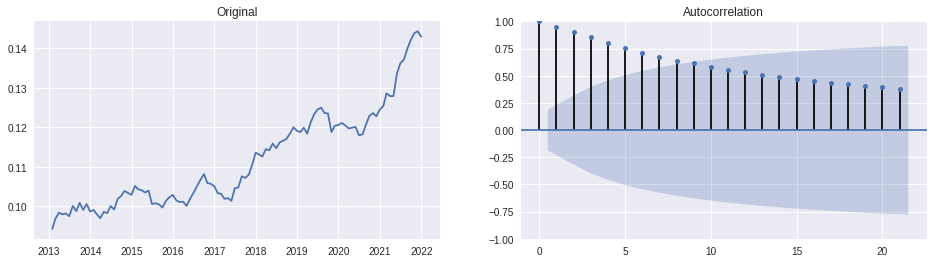

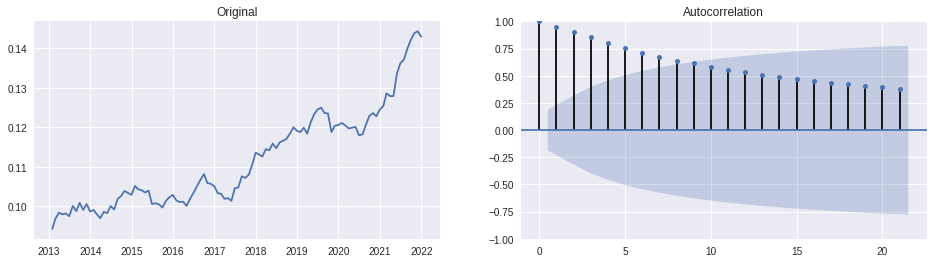

In [270]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.Female)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df.Female, ax=ax2)

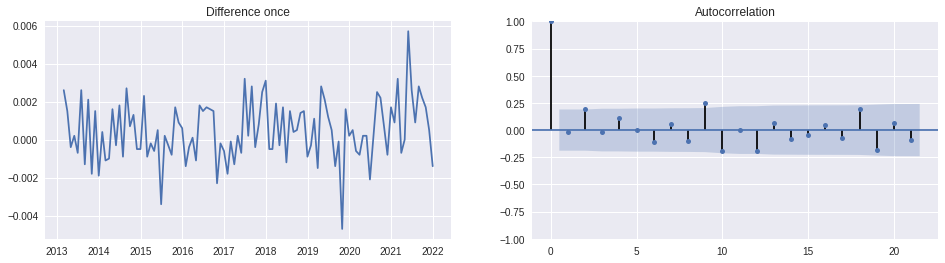

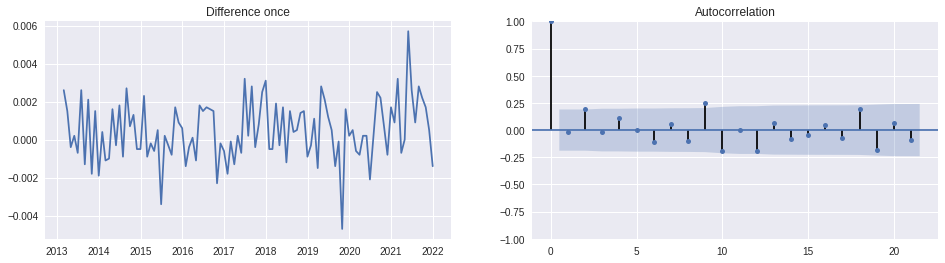

In [271]:
diff = df.Female.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2)

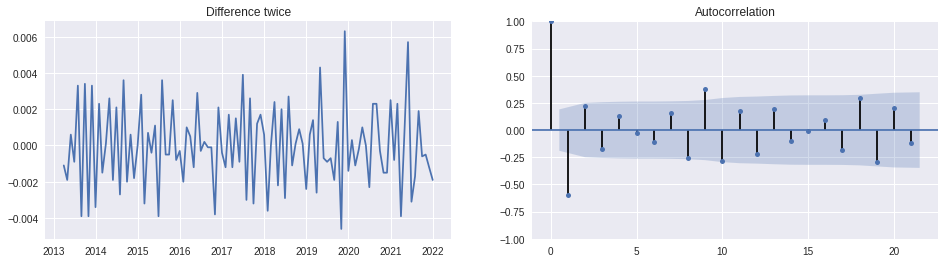

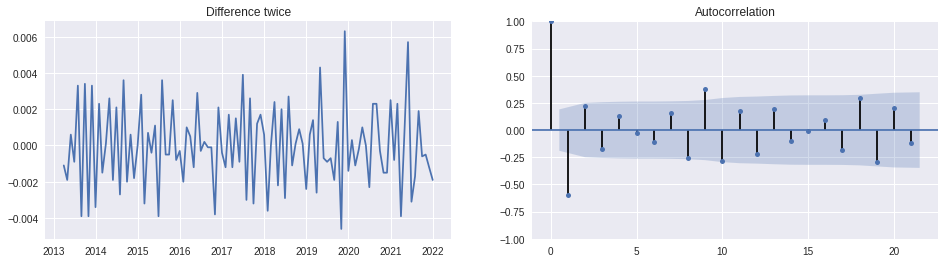

In [272]:
diff = df.Female.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2)

In [273]:
#!pipenv install --skip-lock pmdarima

from pmdarima.arima.utils import ndiffs

In [274]:
ndiffs(df.Female, test="adf")

1

So 1 is the loneliest number but also the magic number for differencing.

p
p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors.

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags.

In [275]:
from statsmodels.graphics.tsaplots import plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


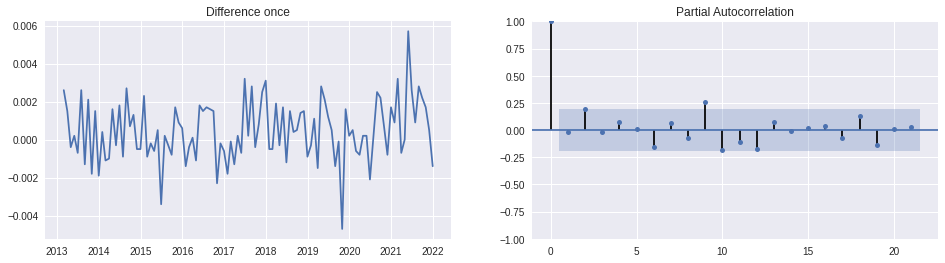

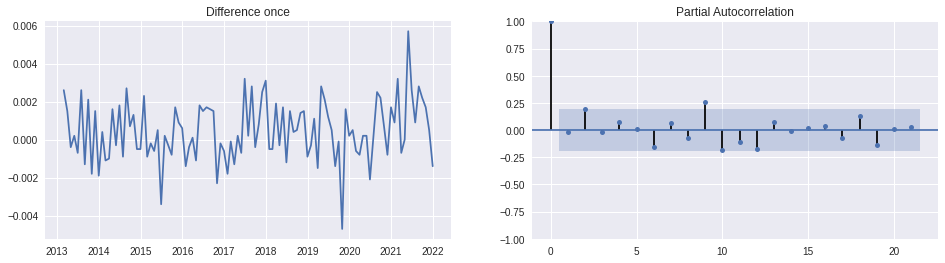

In [276]:
diff = df.Female.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)

We can observe that the PACF lag 9 is significant as it's above the significance line.

q
q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.


We can look at the ACF plot for the number of MA terms (looks to be about 3).

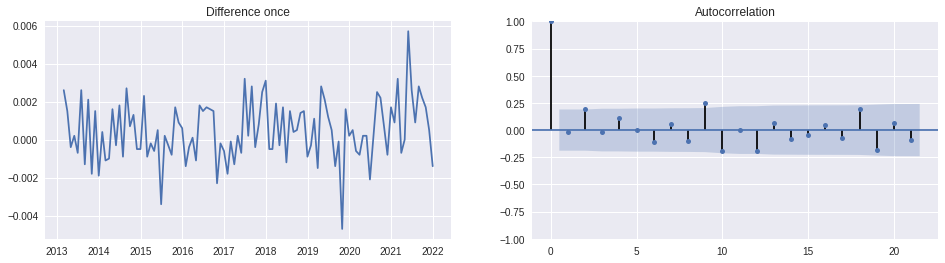

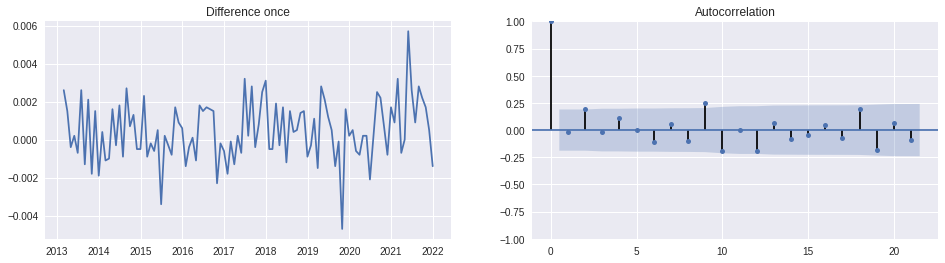

In [277]:
diff = df.Female.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)

# Fitting the ARIMA Model

In [278]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [326]:
model=ARIMA(df['Female'].astype(float),order=(0, 1, 0))
model_fit=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [327]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 Female   No. Observations:                  108
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 534.528
Date:                Sat, 29 Jan 2022   AIC                          -1067.056
Time:                        15:59:29   BIC                          -1064.383
Sample:                    01-31-2013   HQIC                         -1065.972
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.666e-06   3.16e-07      8.449      0.000    2.05e-06    3.29e-06
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.45
Prob(Q):                              0.88   Pr

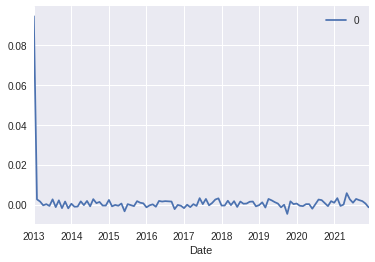

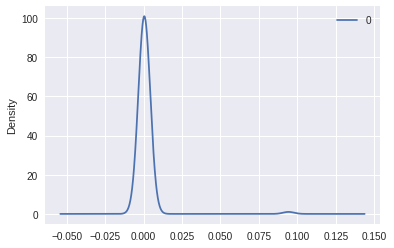

                0
count  108.000000
mean     0.001323
std      0.009166
min     -0.004700
25%     -0.000600
50%      0.000300
75%      0.001625
max      0.094300


In [328]:
from matplotlib import pyplot
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

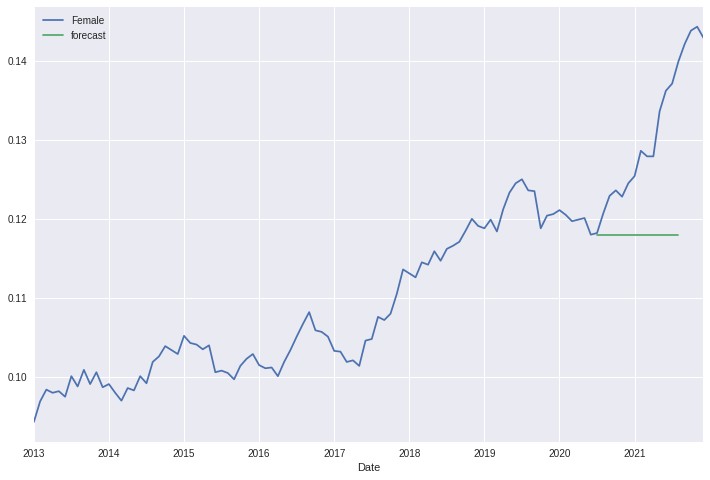

In [329]:
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['Female','forecast']].plot(figsize=(12,8))

In [330]:
import statsmodels.api as sm

In [332]:
model=sm.tsa.statespace.SARIMAX(df['Female'],order=(0, 1, 0),seasonal_order=(1,1,1,12))
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [333]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               Female   No. Observations:                  108
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 459.906
Date:                              Sat, 29 Jan 2022   AIC                           -913.813
Time:                                      15:59:53   BIC                           -906.151
Sample:                                  01-31-2013   HQIC                          -910.717
                                       - 12-31-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4334      0.137     -3.175      0.001      -0.701      -0.166
ma.S.L12      -0.3452      0.207     -1.668      0.095      -0.751       0.060
sigma2      3.362e-06   5.74e-07      5.858      0.000    2.24e-06    4.49e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.30
Prob(Q):                              0.74   Prob(JB):                         0.86
Heteroskedasticity (H):               1.35   Skew:                            -0.09
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

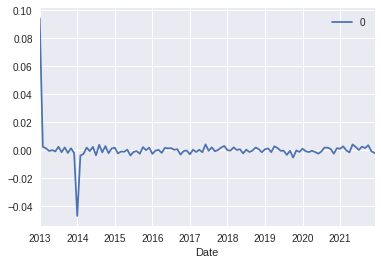

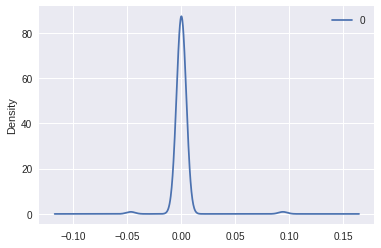

                0
count  108.000000
mean     0.000593
std      0.010335
min     -0.046750
25%     -0.001153
50%      0.000063
75%      0.001687
max      0.094300


In [334]:
from matplotlib import pyplot
residuals = pd.DataFrame(results.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

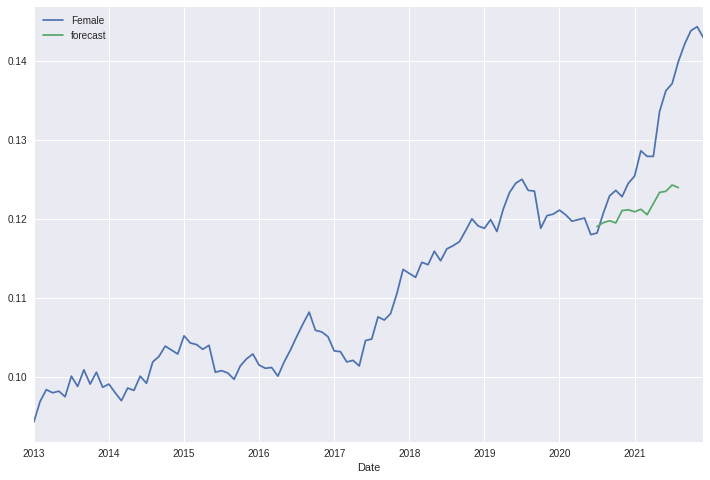

In [335]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['Female','forecast']].plot(figsize=(12,8))

In [336]:
from pandas.tseries.offsets import DateOffset
import datetime as dt
import pandas as pd
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,60)]

In [337]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [338]:
future_datest_df.tail()

,Female,forecast
2026-07-31,NaN,NaN
2026-08-31,NaN,NaN
2026-09-30,NaN,NaN
2026-10-31,NaN,NaN
2026-11-30,NaN,NaN


In [339]:
future_df=pd.concat([df,future_datest_df])

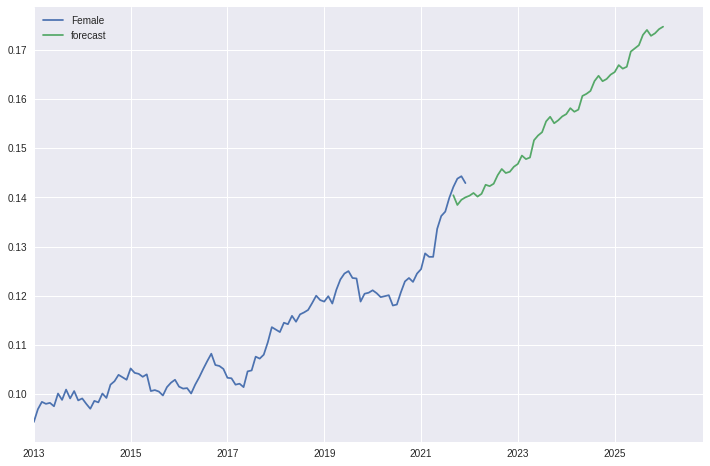

In [340]:
future_df['forecast'] = results.predict(start = 104, end = 156, dynamic= True)  
future_df[['Female', 'forecast']].plot(figsize=(12, 8)) 

In [323]:
from pmdarima.arima import auto_arima

In [325]:
model = auto_arima(
    df.Female,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=6,
    max_q=6,
    m=1,  # frequency of series
    d=None,  # determine 'd'
    seasonal=False,  # no seasonality
    trace=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1069.603, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1073.623, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1071.645, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1071.616, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1067.056, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.443 seconds


In [352]:
len(df)

108

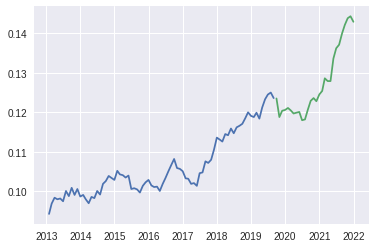

In [353]:
train = df[:80]
test = df[-28:]
plt.plot(train)
plt.plot(test)

In [354]:
arima_model = auto_arima(
    train.Female,
    start_p=0, 
    start_q=0,
    test="adf",
    max_p=6,
    max_q=6,
    m=1,  # frequency of series
    d=None,  # determine 'd'
    seasonal=False,  # no seasonality
    trace=True,
    stepwise=True, random_state=20, n_fits=50
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-806.938, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-806.626, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-806.051, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-803.781, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-806.792, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.789 seconds


In [355]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 405.469
Date:                Sat, 29 Jan 2022   AIC                           -806.938
Time:                        16:12:02   BIC                           -802.199
Sample:                             0   HQIC                          -805.039
                                 - 80                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      2.308      0.021    5.59e-05       0.001
sigma2      2.038e-06   3.96e-07      5.153      0.000    1.26e-06    2.81e-06
===================================================================================
Ljung-Box (L1) (Q):                   1.67   Jarque-Bera (JB):                 1.42
Prob(Q):                              0.20   Prob(JB):                         0.49
Heteroskedasticity (H):               0.93   Skew:                             0.01
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [358]:
prediction = pd.DataFrame(arima_model.predict(n_periods=28), index=test.index)
prediction.columns=['predicted_Female']
prediction.tail(5)

,predicted_Female
Date,
2021-08-31,0.132495
2021-09-30,0.132866
2021-10-31,0.133237
2021-11-30,0.133607
2021-12-31,0.133978


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Unrecognized location 'Left corner'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  """


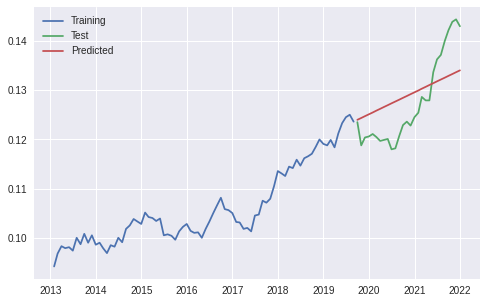

In [357]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc="Left corner")
plt.show()

In [360]:
from sklearn.metrics import r2_score
test['predicted_Female'] = prediction
r2_score(test['Female'], test['predicted_Female'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.4590160032895353